# Křivkový integrál

> Klasickou aplikací křivkového integrálu je práce a potenciál. Nás bude zajímat spíše tok, proto se zde zaměříme na tok vektorového pole uzavřenou křivkou. Můžeme si vektorové pole představit jako rychlostní pole udávající, jak ve kterém místě fouká vítr a snažíme se vypočítat, jestli v množině oharaničené křivkou vzduchu ubývá, či přibývá. 

Budeme se zajímat o tok vektorového pole křivkou. Může jít například o tok tepla. Pokud je křivka uzavřená, vypočteme celkové teplo, které proteče do oblasti obepnuté touto křivkou. Podobně je možné modelovat difuzní tok a zjišťovat, jaké množství difundující látky se dostane do oblasti. Znaménková konvence pro kladně orientované křivky (při obíhání ve směru rostoucího parametru je oblast obepnutá křivkou po levé ruce) je taková, že tok ven je kladný a tok dovnitř záporný. 

In [1]:
import numpy                     # knihovna na numerické výpočty (goniomerické funkce, gradient, 2D mřížka a dělení intervalu, ...)
import scipy.integrate           # knihovna na technické výpočty (integrál)
import matplotlib.pyplot as plt  # knihovna na kreslení

## Křivkový integrál a obsah množiny

Budme uvažovat uzavřenou křivku ve tvaru srdce s parametrickými rovnicemi 
\\[ \vec r(t) = \begin{pmatrix} -16 \sin^3(t) \cr 13\cos(t)-5\cos(2t)-2\cos(3t)-\cos(4t)\end{pmatrix},\quad t\in[0,2\pi].\\]
Jako výsledný tok touto křivkou dostaneme bilance mezi přírůstkem a úbytkem tepla (nebo obecně stavové veličiny) uvnitř. Křivka je orientována proti směru hodinových ručiček a kladný tok je tok ven ze srdce. 

Pro ujasnění si souvilosti s s divergencí se nám bude hodit i obsah. Ten vypočteme jako křivkový integrál \\[\oint_C x\mathrm dy.\\] Výpočet můžeme zrealizovat přepisem na Riemannův integrál tak, že ručně zadáme derivaci křivky. Díky tomu nebudeme muset používat aproximaci pomocí centrálních diverencí. Je ale možné počítat i numericky. Pro srovnání použijeme obě metody.

Obsah pomocí analyticky definovaných derivací je 565.4866776450867
Obsah numerickým výpočtem derivací je 565.4789727722859


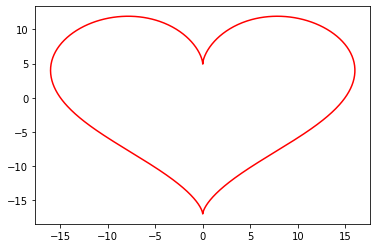

In [2]:
def krivka(t):                                    # parametrické rovnice křivky ve tvaru srdce
   return [ -16*numpy.sin(t)**3 , 13*numpy.cos(t)-5*numpy.cos(2*t)-2*numpy.cos(3*t)-numpy.cos(4*t)] 

def krivka_derivace(t):                           # derivace rovnice křivky ve tvaru srdce
   return [ -16*3*numpy.sin(t)**2*numpy.cos(t) , -13*numpy.sin(t)+5*numpy.sin(2*t)*2+2*numpy.sin(3*t)*3+numpy.sin(4*t)*4]

t = numpy.linspace(0, 2*numpy.pi, 1000)           # interval mezi 0 a 2*pi rozdělený na 1000 dílků
 
# Výpočet pomocí ručně zadané derivace křivky
Obsah = scipy.integrate.simps( krivka(t)[0]*krivka_derivace(t)[1] , t) # výpočet integrálu x*dy přepisem na Riemannův integral a integrací Simpsonovým pravidlem
print("Obsah pomocí analyticky definovaných derivací je %s"%str(Obsah))

# Výpočet numerickou derivací křivky
Obsah_num = scipy.integrate.simps( krivka(t)[0] * numpy.gradient(krivka(t)[1],t) , t)
print("Obsah numerickým výpočtem derivací je %s"%str(Obsah_num))

x,y = krivka(t)
plt.plot(x,y, color='red');



## Křivkový integrál a tok vektorového pole

Definujme nástroje pro výpočet toku. Pro lepší představu budeme uvažovat teplotní tok, který je záporně vzatým gradientem teploty. Komponenty vektorového pole \\[ \vec q = -\nabla T\\] jsou \\[q_x=-\frac{\partial T}{\partial x}\\] a \\[q_y=-\frac{\partial T}{\partial y}.\\]
Tok křivkou $C$ vypočteme jako křivkový integrál 
\\[ \int_C -q_y\mathrm dx + q_x \mathrm dy.\\]

Pro jednoduchost použijeme poměrně jednoduchou metodu výpočtu celkového toku křivkou. 

* Hranici si rozdělíme na $N$ dílků podle hodnoty parametru parametrizujícího křivku. Vypočteme tok na každém dílku a sečteme je integrálem za použití Simpsonovy metody. Pro lepší ilustraci si graf takto integrované funkce kreslíme do pravého obrázku. Začátek i konec odpovídá hornímu bodu uprostřed srdce, tj. bodu o souřadnicích $(0,5)$. 
* Tok pole $(q_x,q_y)$ na každém dílku vypočteme skalárním součinem tečného vektoru ke křivce s polem $(-q_y,q_x)$. 
* Tečný vektor určíme pomocí centrální diference. Poslouží k tomu vestavěná funkce `gradient` z knihovny `numpy`. 
* Vektorové pole v daném místě křivky vypočteme ručně pomocí centrální diference. 

Celkový tok vydělíme obsahem srdce. Tím budeme mít změnu na jednotku obsahu, což odpovídá divergenci. Zejména v případech, kdy je divergence konstantní (teplota dána lineární nebo kvadratickou funkcí), očekáváme shodu tohoto podílu s divergencí.


In [3]:
def teplota (x,y): 
  return 20-x

def KRESLI():
    global teplota                                # pouzijeme globalne definovane funkce
    global krivka
    global Obsah
    y, x = numpy.mgrid[-20:20:20j, -20:20:20j]    # mrizka pro kresleni gradientu a barevne mapy funkce dvou promennych
    z = teplota(x, y)                             # evaluation of the function on the grid
    grady, gradx = numpy.gradient(z)              # gradient vysky
    qx, qy = -gradx, -grady                       # tok, pole opačné ke gradientu

    fig, axes = plt.subplots(1, 2, figsize=(30,12))  # inicializace grafiky, dva grafy vedle sebe
    
    ## Vykreslení teploty a toku tepla
    ax=axes[0]                                    # začneme kreslit do prvního grafu
    cmap = plt.get_cmap('hot')                    # nastaveni schema pro barevnou mapu
    output = ax.pcolormesh(x, y, z, cmap=cmap, shading='gouraud') # vykresleni barevne mapy pomocí zvolené barevné mapy a vyhlazování přechodů
    plt.colorbar(output, ax=ax)                   # barevný sloupec s hodnotami vedle grafu
    ax.quiver(x, y, qx, qy, color='blue')         # vykreslení toku
    
    ## Vykreslení křivky
    N = 1000                                      # počet dělení intervalu pro parametr t
    t = numpy.linspace(0, 2*numpy.pi, N)          # interval mezi 0 a 2*pi rozdělený na N dílků, uzlové body křivky
    x, y = krivka(t)                              # kartézské souřadnice bodů na křivce
    ax.plot(x,y, color='green', lw=4)             # vykreslení křivky
    ax.set_aspect(1)                              # budeme používat stejné měřítko na obou osách

    ## Výpočet integrálu
    dx = numpy.gradient(x,t)                      # derivace první komponenty krivky pomocí centralni diference (viz napoveda k funkci gradient)
    dy = numpy.gradient(y,t)                      # derivace druhé komponenty křivky
    dt = t[1] - t[0]                              # vzdálenost mezi uzlovými body
    h = dt                                        # krok pro výpočet derivace, je také možné derivace počítat analyticky, což by pravděpodobně navýšilo přesnost
    qx, qy = [ -( teplota(x+h,y)-teplota(x-h,y) ) / (2*h) , -( teplota(x,y+h)-teplota(x,y-h) ) / (2*h) ] 
                                                  # (qx,qy) je vektorové pole opačné ke gradientu vypočtené pomocí centrální diference v bodech křivky
    I = - qy * dx + qx * dy                       # integrand po přepisu křivkového integrálu na Riemannův, 
                                                  # skalární součin tečného vektoru (dx,dy) ke křivce s vektorem kolmým (-qy,qx) k toku (qx,qy)
    integral = scipy.integrate.simps(I,t)         # celkový tok přes hranici srdce, tok orientovanou křivkou

    podil = integral / Obsah                      # Podíl toku a obsahu množiny. Střední hodnota divergence.
    print("Výsledný tok je %s.\nPodíl toku a obsahu množiny je %s."%(str(integral),str(podil)))

    ax = axes[1]                                  # začneme kreslit do druhého grafu
    ax.plot(I)                                    # vykreslení součinu tečného vektoru ke křivce s kolmým polem na tok, příspěvek k celkovému toku
    ax.set_title("Průběh příspěvků k celkovému toku")

## Tok vektorového pole s konstantní divergencí

Využijeme předpřipravené funkce vždy na vektorové pole mající konstantní divergenci. To znamená, že tok zesiluje ve všech místech stejnou intenzitou. Pokud by byla úloha stacionární, podle difuzní rovnice by případné zesilování toku šlo na vrub zdrojům či spotřebičům. Konstantnost divergence poté znamená, že tyto zdroje či spotřebiče jsou rozloženy rovnoměrně v rovině.

Výsledný tok je 3.2118275053449885e-13.
Podíl toku a obsahu množiny je 5.679758042612651e-16.


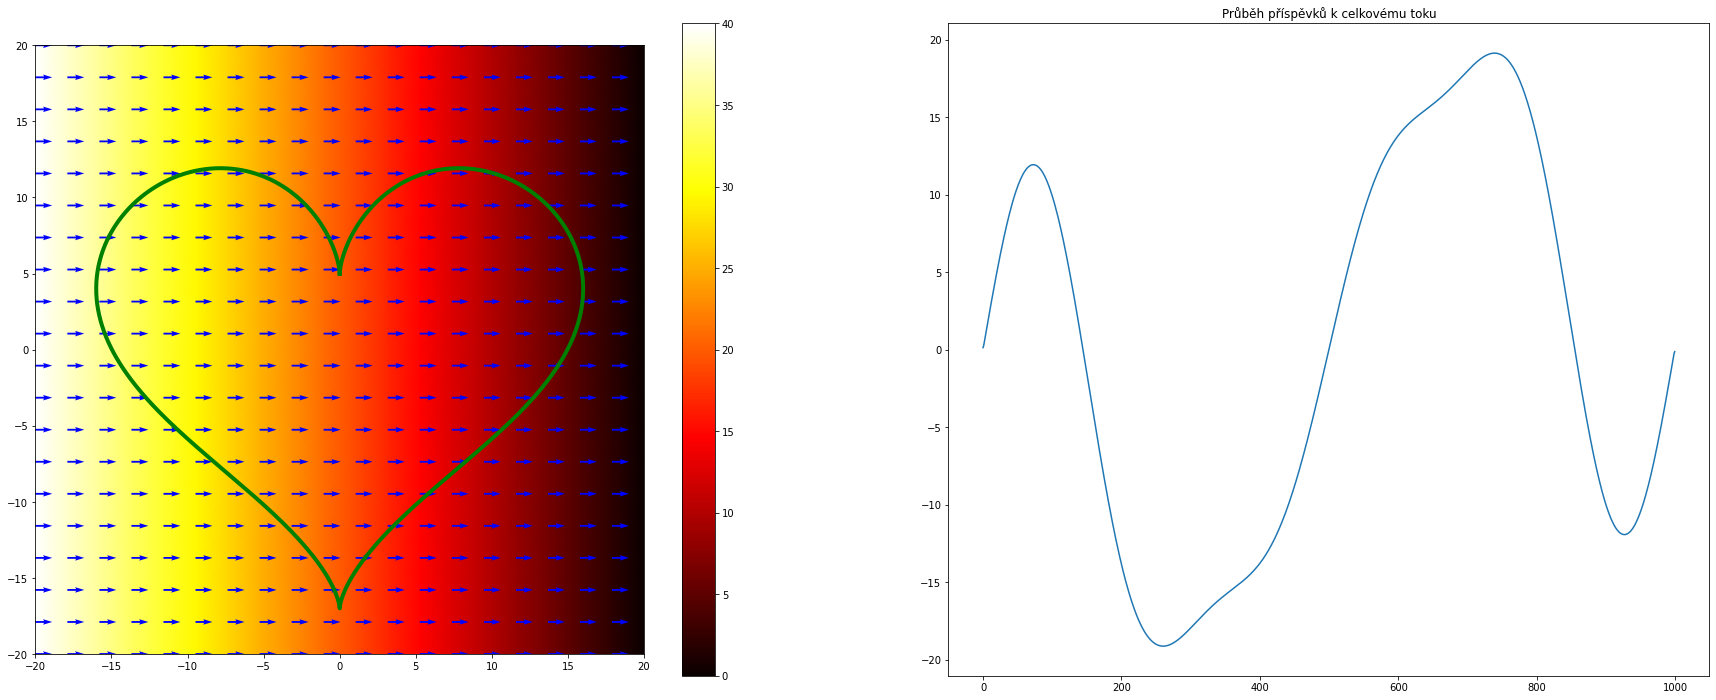

In [4]:
def teplota (x,y): 
   return 20-x
KRESLI()

Teplota na obrázku výše je dána vztahem \\[T(x,y)=20-x.\\] Roste tedy konstantní rychlostí směrem doleva. Teplo teče doprava. Situace je krásně symetrická. Teplo, které na levé straně do srdce vteče, na pravé straně vyteče. Tuto symetrii je možno odhadnout z obrázku toku. Středově symetrická je i křivka vpravo. Divergence vektorového pole popisujícího tok tepla je nulová, \\[\nabla \cdot (-\nabla T)=0.\\]
Výpočet z definice programem Sage je [zde](https://sagecell.sagemath.org/?z=eJxtj89qhDAQxu-C7xDwsDHo4rptDwWvvkQpMk2yJWj-EKNEn75JxD0snVx-k5lv5psVLL64S5lnRVGgHRgogR6LGimvkNFUOEAzR06PaLRiHfWSZ73HvtrKrm6JD9n2zLY8O16cZfWqBOXIWH1IQ9VjFxpvH2QWKiAh9zzb4t_tTqieA9XvCVoSsE14jxjhLUCe7bG9OZdIvh8bDFiQ3Nk8c1KoyknwXVO1xIino38iVY4GpmfYuRLD4bWTYDCaQP4wQObTYN9F8xXaumg4AK77rep9GTz9WmCCK_cqujLxeCQVTuKkRGVcpxbJraAwDUI5HgZMeOXUaYtfjJRXpt0QTmQLdWfPuTD6CJFORvHm8qv5_gMoX4cO&lang=sage&interacts=eJyLjgUAARUAuQ==), křivka je předepsána, nastavte si požadovanou funkci.

Výsledný tok je -2261.9159109974307.
Podíl toku a obsahu množiny je -3.9999455343792634.


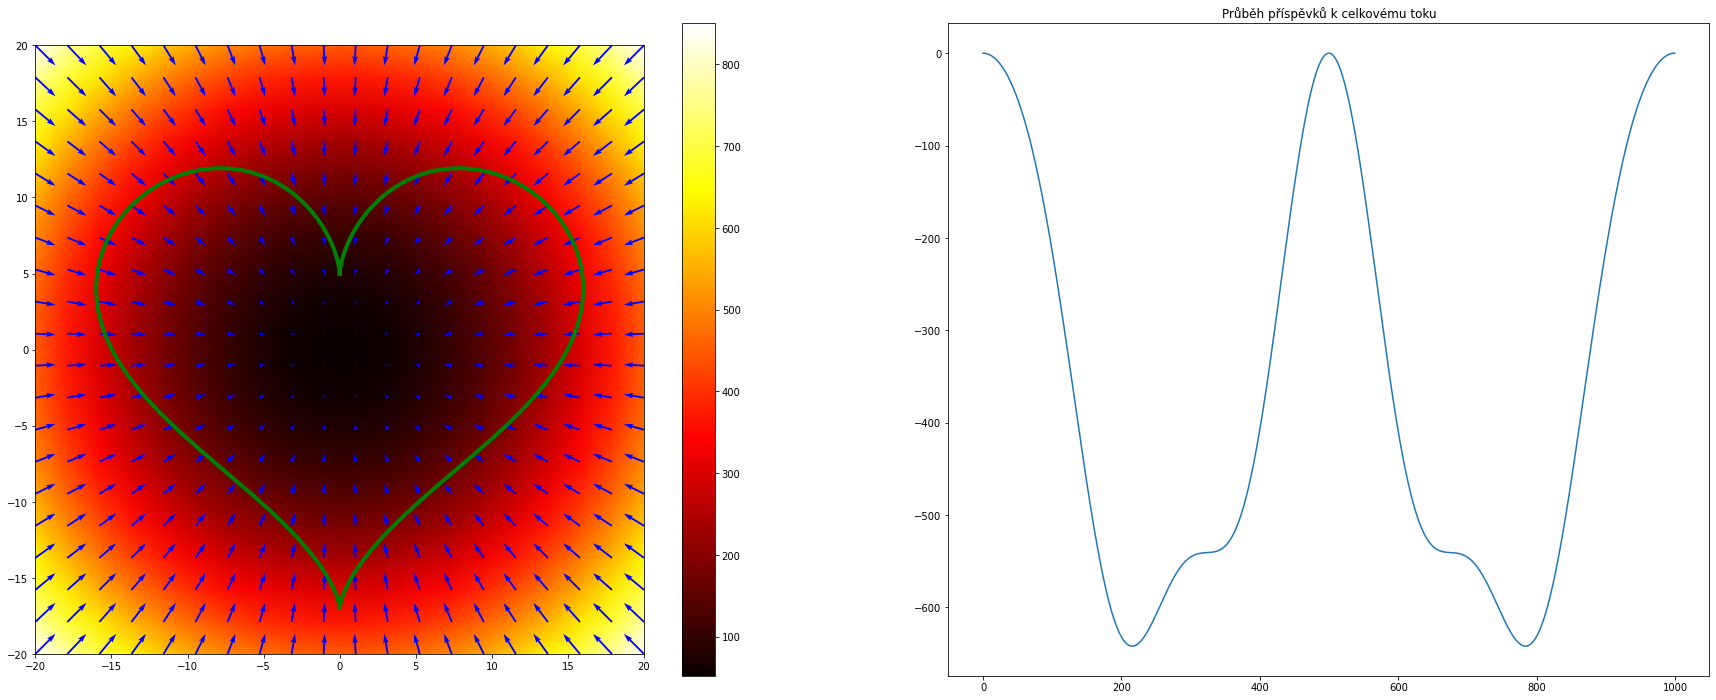

In [5]:
def teplota (x,y): 
  return (50+(x**2+y**2)) 
KRESLI()

Teplota na obrázku výše je dána vztahem \\[T(x,y)=50+x^2+y^2.\\] Roste tedy směrem od středu. Uprostřed je nejnižší teplota (nejtmavší barva) a teplo teče do srdce. Tok je záporný. Divergence vektorového pole popisujícího tok tepla je konstantní záporná, \\[\nabla \cdot (-\nabla T)=-4.\\]

Výsledný tok je 226.19159109974353.
Podíl toku a obsahu množiny je 0.39999455343792717.


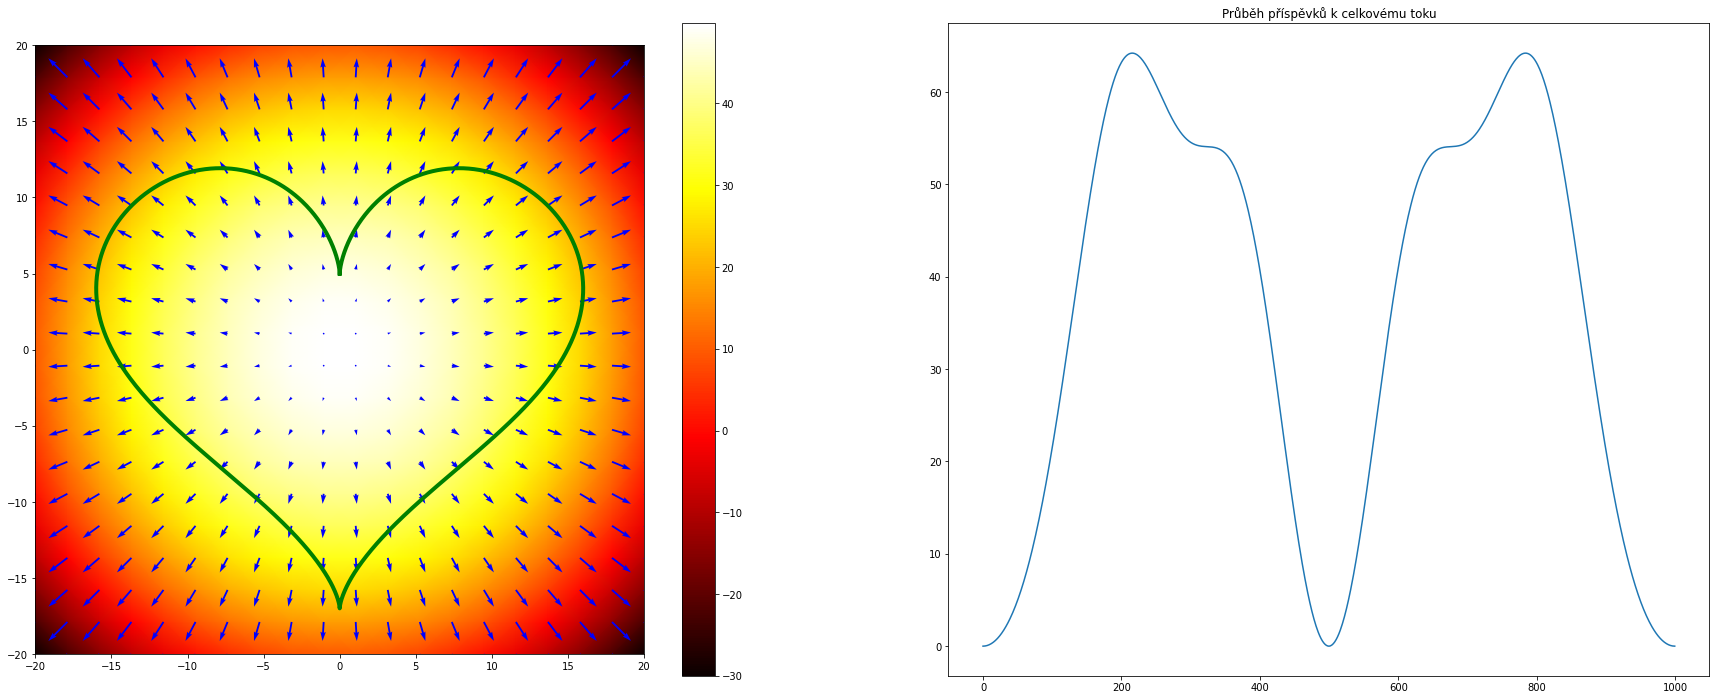

In [6]:
def teplota (x,y): 
  return 50-(x**2+y**2)*0.1
KRESLI()  

Teplota na obrázku výše je dána vztahem \\[T(x,y)=50-\frac {x^2+y^2}{10}.\\] Klesá tedy směrem od středu. Uprostřed je nejvyšší teplota (žlutá barva) a teplo teče ze srdce. Tok je kladný. Divergence vektorového pole popisujícího tok tepla je konstantní kladná, \\[\nabla \cdot (-\nabla T)=\frac 4{10}.\\]

Výsledný tok je -11.309579455446585.
Podíl toku a obsahu množiny je -0.019999727495869944.


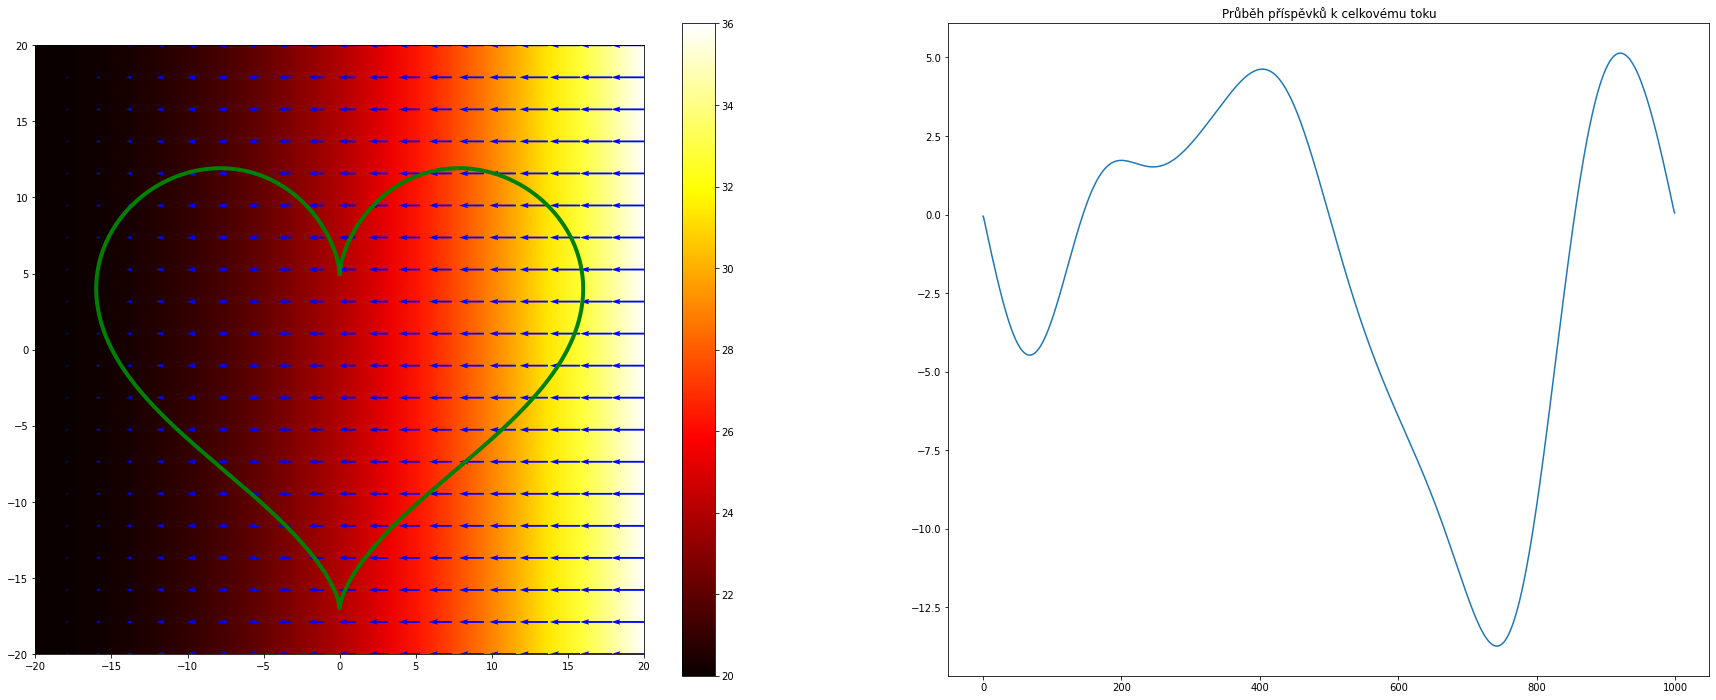

In [7]:
def teplota (x,y): 
  return 20+0.01*(x+20)**2
KRESLI()  

Teplota na obrázku je dána vztahem \\[T=20+0.01(x+20)^2.\\] Roste tedy nelineárně směrem doprava (stále vyšší rychlostí). Tok v pravé části srdce je intenzivnější než tok v levé. Tok v pravé části je dovnitř a tedy záporný. Tok v levé části je kladný a malý. Celkový tok je tedy záporný. Divergence vektorového pole popisujícího tok tepla je konstantní a záporná, \\[\nabla \cdot (-\nabla T)=-0.02.\\]

Výsledný tok je 3.98034105099517e-06.
Podíl toku a obsahu množiny je 7.038788371763074e-09.


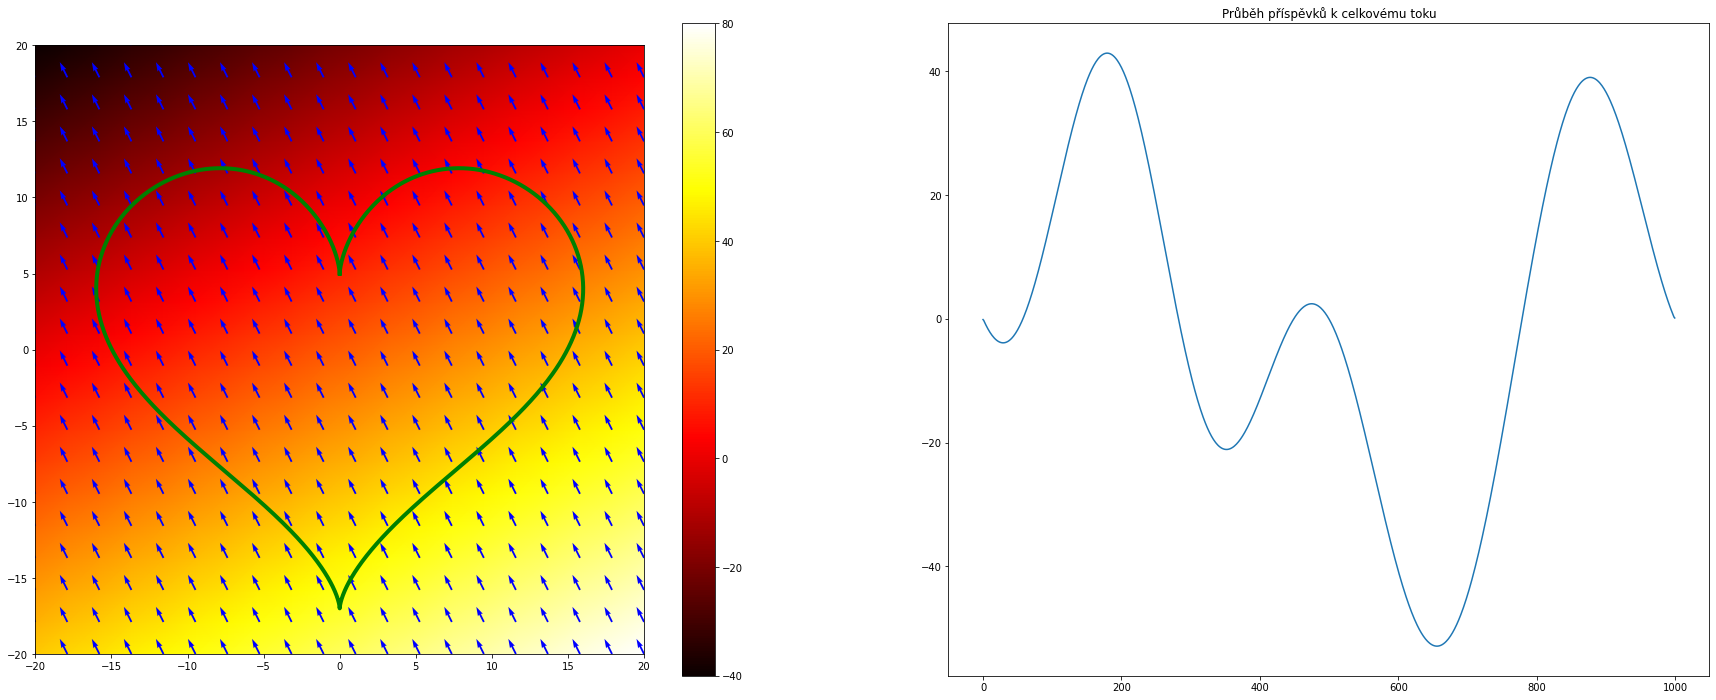

In [8]:
def teplota (x,y): 
    return 20-2*y+x
KRESLI()    
  

Teplota je dána vztahem \\[T(x,y)=20+x-2y.\\] Roste tedy směrem dolů. Proto teplo teče z pravého dolního rohu do levého horního. Narozdíl od konstantního toku přecházejícího přes srdce zleva doprava již situace není symetrická. Protože však tok nikde nezesiluje ani nezeslabuje, je přirozené, že teplo které na jednom konci do srdce vteče na druhém vyteče. Celkový tok je tedy nulový. Divergence vektorového pole popisujícího tok tepla je nulová, \\[\nabla \cdot (-\nabla T)=0.\\]

Výsledný tok je 56.547894889285985.
Podíl toku a obsahu množiny je 0.0999986332565324.


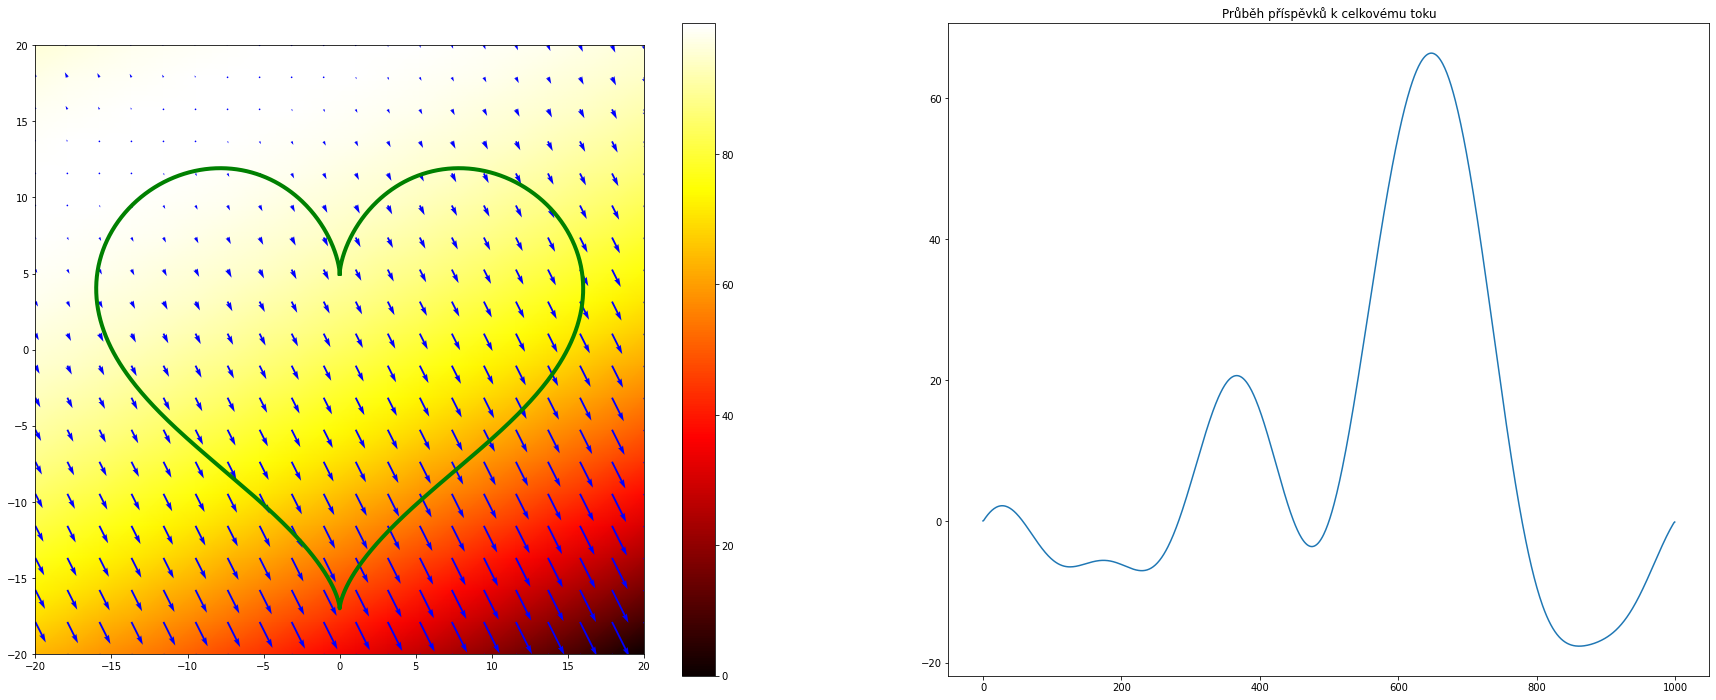

In [9]:
def teplota (x,y): 
   return 100-0.01*(40+x-2*y)**2 
KRESLI()   

Teplota je dána vztahem  \\[T(x,y)=100-0.01(40+x-2y)^2 \\]
Teplo teče směrem doprava dolů. Vektory se postupně prodlužují a tok tedy nabývá na intenzitě. Tato intenzivnější část je v místě, kde teplo teče ven, tj. v místě, kde je tok kladný. Záporné příspěvky v levém horním rohu jsou zanedbatelné a celkový tok je kladný. Divergence vektorového pole popisujícího tok tepla je konstantní a kladná, platí \\[\nabla \cdot (-\nabla T)=0.1.\\]

## Tok s nekonstantní divergencí

V případě toku s konstantní divergencí jsme viděli, že podíl toku přes hranici a obsahu množiny byl numericky roven této divergenci. Toto je pochopitelné a plyne to z fyzikální interpretace pojmu divergence. V případě toku s nekonstantní divergencí máme v tomto podíle jakousi zprůměrovanou hodnotu. V jakém smyslu je zprůměrována si ukážeme v pasáži věnované *dvojnému integrálu*.

In [10]:
h=0.01
def divergence_gradientu (x,y):
    global h     
    return (vyska(x+h,y) + vyska(x-h,y) + vyska(x,y+h) + vyska(x,y-h) - 4* vyska(x,y) ) / h**2

Výsledný tok je 56.547894889285985.
Podíl toku a obsahu množiny je 0.0999986332565324.


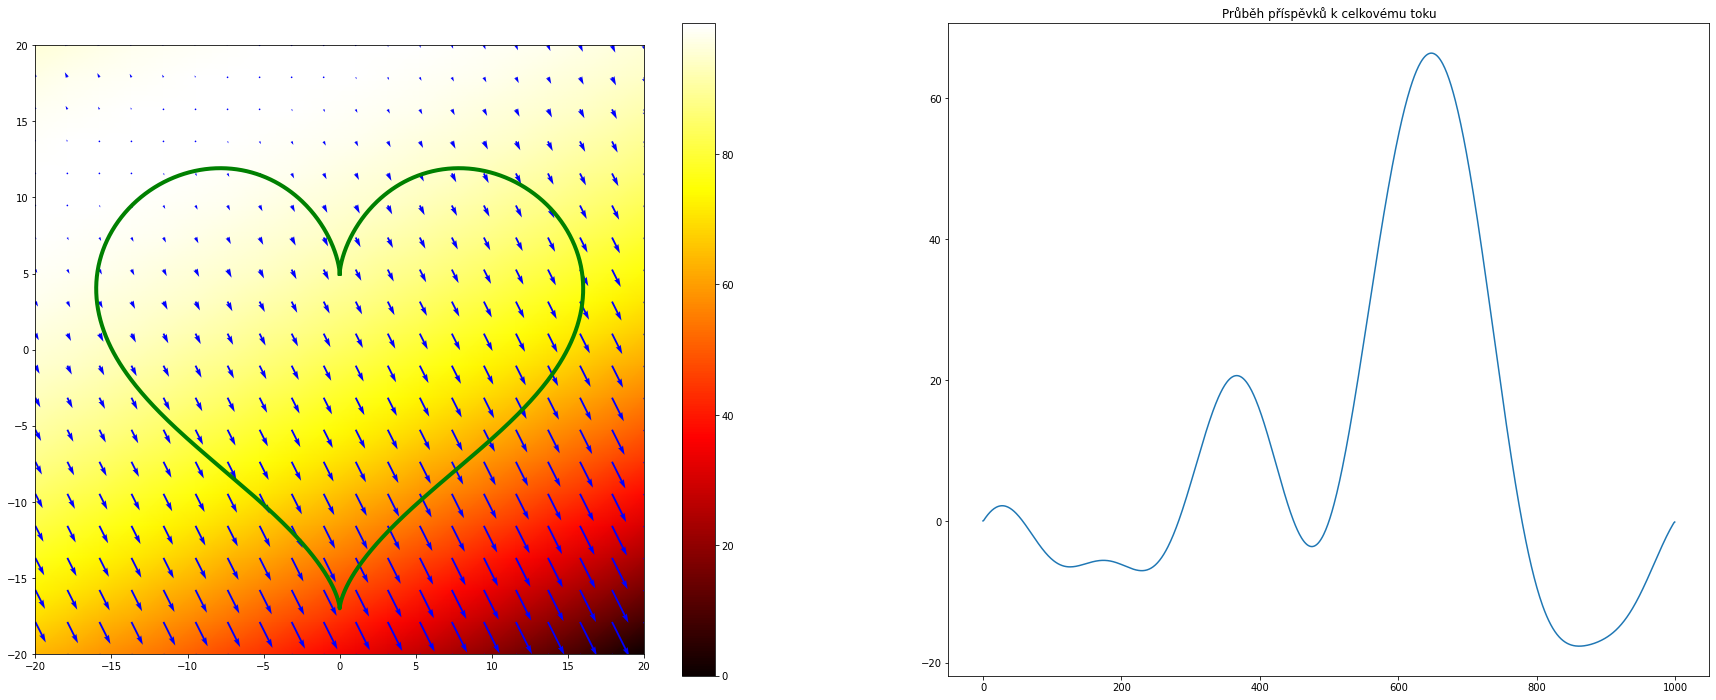

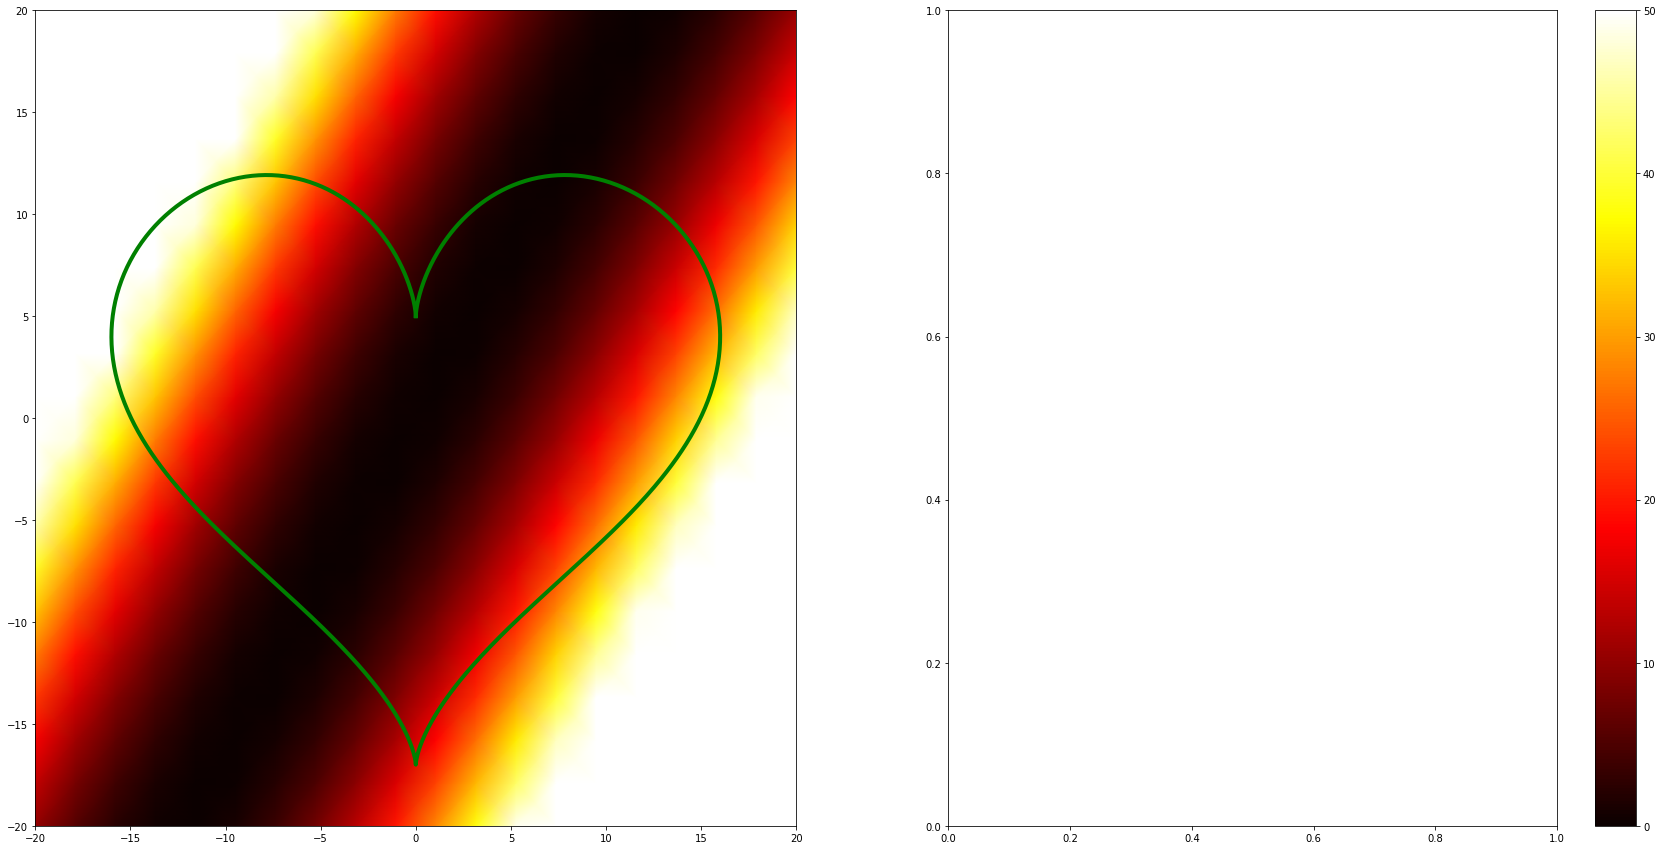

In [11]:
def vyska (x,y): 
    return 20+0.01*(x-0.6*y+.1)**4
KRESLI()

y, x = numpy.mgrid[-20:20:20j, -20:20:20j]  # mrizka pro kresleni gradientu a barevne mapy funkce dvou promennych
z = divergence_gradientu(x, y) # evaluation of the function on the grid

# inicializace grafiky, dva grafy vedle sebe
fig, axes = plt.subplots(1, 2, figsize=(30,15))
ax=axes[0]  # začneme kreslit do prvního grafu
    
cmap = plt.get_cmap('hot')       # nastaveni schema pro barevnou mapu
output=ax.pcolormesh(x, y, z, cmap=cmap, shading='gouraud', vmax=50, vmin=0) # vykresleni barevne mapy
#output=ax.pcolormesh(x, y, z, cmap=cmap, shading='gouraud') # vykresleni barevne mapy
#ax.quiver(x, y, vx, vy, color='blue', lw=.01) # vykreslení toku
plt.colorbar(output) # barevny sloupec s hodnotami vedle grafu

N = 1000
t = numpy.linspace(0, 2*numpy.pi, N) # uzlove body krivky
dt = (t[-1] - t[0] ) / N # vzdalenost mezi uzlovymi body
ax.plot(krivka(t)[0],krivka(t)[1], color='green', lw=4) # vykresleni krivky


ax=axes[1]  # začneme kreslit do druhého grafu
#ax = plt.axes(projection='3d')
#surf = plt.plot_surface(x, z, z, cmap=cm.coolwarm,                        linewidth=0, antialiased=False)



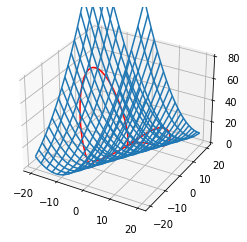

In [12]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

y, x = numpy.mgrid[-20:20:20j, -20:20:20j]    # mrizka pro kresleni gradientu a barevne mapy funkce dvou promennych
z = divergence_gradientu(x, y)                # evaluation of the function on the grid

# Plot the surface.
#surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.plot_wireframe(x, y, z)

# Customize the z axis.
ax.set_zlim(0, 80)

N = 1000                                      # počet dělení intervalu pro parametr t
t = numpy.linspace(0, 2*numpy.pi, N)          # uzlové body křivky
X, Y = krivka(t)
Z = divergence_gradientu(X,Y)
plt.plot(X,Y,Z, color='red')


